<a href="https://colab.research.google.com/github/urness/CS167Fall2025/blob/main/Notebook5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 5

# CIFAR-10 Dataset visualization
Let's import [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) from PyTorch's [_torchvision.datasets_ module](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10)
  - Each image size: __32x32x3__
    - Note that these are color images, unlike Fashion-MNIST, which was grayscale with only one channel.
  - Each image is associated with a label from __10 classes__
  - Training set of __50000__ examples and test set of __10000__ examples

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets # torchvision has many deep learning benchmark datasets Fashion-MNIST, CIFAR-10, Caltech-50, etc
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

training_data = datasets.CIFAR10(
    root="/content/drive/MyDrive/CS167/datasets", # CHANGE THIS TO POINT TO YOUR OWN PATH
    train=True,          # if True, creates dataset from training set, otherwise creates from test set.
    download=True,
    transform=ToTensor() # specify the feature and label transformations
)

test_data = datasets.CIFAR10(
    root="/content/drive/MyDrive/CS167/datasets", # CHANGE THIS TO POINT TO YOUR OWN PATH
    train=False,         # if True, creates dataset from training set, otherwise creates from test set.
    download=True,
    transform=ToTensor() # specify the feature and label transformations
)

labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

# Visualize a random set of images and their the labels from the training split
figure = plt.figure(figsize=(5, 5))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(np.moveaxis(img.numpy(), 0, -1)) # converting a tensor of size: [3, 32, 32] --> numpy array of size: [32, 32, 3]

plt.show()

  5%|▍         | 7.93M/170M [00:18<06:11, 438kB/s]


KeyboardInterrupt: 

In [ ]:
# check to see if torch.cuda is available, otherwise it will use CPU
import torch
import torch.nn as nn
import numpy as np
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")
# if it prints 'cuda' then colab is running using GPU device

Using cuda device


In [ ]:
# Step 1: load the Torch library and other utilities
#----------------------------------------------------

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import time


In [ ]:
# Step 2: load the dataset, ie, we are experimenting with MNIST
#--------------------------------------------------------------------------------------------------
training_data = datasets.CIFAR10(
    root="/content/drive/MyDrive/CS167/datasets", # CHANGE THIS TO POINT TO YOUR OWN PATH
    train=True,          # if True, creates dataset from training set, otherwise creates from test set.
    download=True,
    transform=ToTensor() # specify the feature and label transformations
)

test_data = datasets.CIFAR10(
    root="/content/drive/MyDrive/CS167/datasets", # CHANGE THIS TO POINT TO YOUR OWN PATH
    train=False,         # if True, creates dataset from training set, otherwise creates from test set.
    download=True,
    transform=ToTensor() # specify the feature and label transformations
)

labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

In [ ]:
# Step 3: Create your MLP Network
#--------------------------------------------------------------------------------------------------

import torch
from torch import nn
import pdb

class SimpleMLPv1(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()

    self.network_layers = nn.Sequential(
                nn.Linear(3072, 256),  # linear transformation module (input=784, output=512)
                nn.ReLU(),
                nn.Linear(256, 10) # linear transformation module (input=256, output=10)
                              # usually this number should be equal to the total number of classes in your classification task
    )

  def forward(self, x):
    x = self.flatten(x)
    output = self.network_layers(x)
    return output


In [ ]:
## Step 4: Your training and testing functions
#--------------------------------------------------------------------------------------

def train_loop(dataloader, model, loss_fn, optimizer):
    """
    Executes one full training epoch for the given model.

    Iterates over all batches in the provided DataLoader, performing the following steps:
    - Moves input and target tensors to the selected device (CPU or GPU)
    - Computes predictions and loss for each batch
    - Performs backpropagation and optimizer updates
    - Tracks and prints training loss periodically

    Args:
        dataloader (torch.utils.data.DataLoader):
            The DataLoader providing batches of training data (inputs and labels).
        model (torch.nn.Module):
            The neural network model to be trained.
        loss_fn (torch.nn.Module or callable):
            The loss function used to compute the training loss.
        optimizer (torch.optim.Optimizer):
            The optimizer responsible for updating the model’s parameters.

    Returns:
        float: The average training loss across all batches in this epoch.
    """
    size = len(dataloader.dataset)

    model.train()                   # set the model to training mode for best practices

    size        = len(dataloader.dataset)
    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):

        # compute prediction and loss
        X = X.to(device)                  # send data to the GPU device (if available)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()      # compute gradients
        optimizer.step()     # apply updates
        optimizer.zero_grad()# clear old gradients

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    correct /= size

    return train_loss/len(dataloader), 100*correct

def test_loop(dataloader, model, loss_fn):
    """
    Evaluates the model’s performance on a test (or validation) dataset.

    Runs a forward pass over all batches in the provided DataLoader with gradient
    computation disabled, accumulating loss and accuracy metrics.

    Args:
        dataloader (torch.utils.data.DataLoader):
            The DataLoader providing batches of test or validation data.
        model (torch.nn.Module):
            The trained neural network model to evaluate.
        loss_fn (torch.nn.Module or callable):
            The loss function used to compute the evaluation loss.

    Returns:
        float: The average loss over all test batches.

    Prints:
        Accuracy (% of correct predictions) and average test loss.
    """

    model.eval()                    # set the model to evaluation mode for best practices

    size        = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:

            X = X.to(device)                     # send data to the GPU device (if available)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, 100*correct

In [ ]:

# Step 5: prepare the DataLoader and select your optimizer and set the parameters for learning the model from DataLoader
#------------------------------------------------------------------------------------------------------------------------------

mlp_model = SimpleMLPv1() ## model Class name here
mlp_model.to(device)      ## device should have been determined earlier (at top of notebook)
learning_rate = 1e-3
batch_size_val = 64
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(training_data, batch_size=batch_size_val)
test_dataloader = DataLoader(test_data, batch_size=batch_size_val)


train_losses = []
test_losses  = []
train_accuracy = []
test_accuracy  = []
start_time   = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_acc = train_loop(train_dataloader, mlp_model, loss_fn, optimizer)
    avg_test_loss, test_acc  = test_loop(test_dataloader, mlp_model, loss_fn)
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

print("Done!")

print("Total fine-tuning time: %.3f sec" %( (time.time()-start_time)) )
print("Total fine-tuning time: %.3f hrs" %( (time.time()-start_time)/3600) )

print(mlp_model.__class__.__name__, " model has been trained!")


Epoch 1
-------------------------------
loss: 2.322294  [   64/50000]
loss: 2.293819  [ 6464/50000]
loss: 2.245762  [12864/50000]
loss: 2.270645  [19264/50000]
loss: 2.223915  [25664/50000]
loss: 2.222367  [32064/50000]
loss: 2.254464  [38464/50000]
loss: 2.198715  [44864/50000]
Test Error: 
 Accuracy: 24.1%, Avg loss: 2.186817 

Epoch 2
-------------------------------
loss: 2.222379  [   64/50000]
loss: 2.192877  [ 6464/50000]
loss: 2.100037  [12864/50000]
loss: 2.194495  [19264/50000]
loss: 2.118466  [25664/50000]
loss: 2.123267  [32064/50000]
loss: 2.199455  [38464/50000]
loss: 2.102699  [44864/50000]
Test Error: 
 Accuracy: 28.1%, Avg loss: 2.100069 

Epoch 3
-------------------------------
loss: 2.153443  [   64/50000]
loss: 2.116856  [ 6464/50000]
loss: 1.985583  [12864/50000]
loss: 2.132384  [19264/50000]
loss: 2.044585  [25664/50000]
loss: 2.055617  [32064/50000]
loss: 2.165854  [38464/50000]
loss: 2.032385  [44864/50000]
Test Error: 
 Accuracy: 29.4%, Avg loss: 2.037972 

Epoc

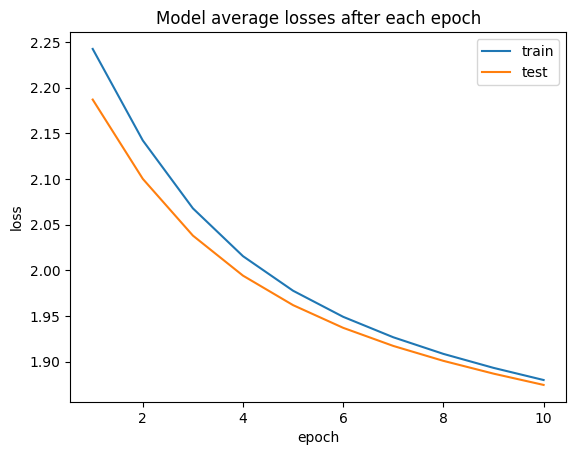

In [ ]:
# visualizing the loss curves
plt.plot(range(1,epochs+1), train_losses)
plt.plot(range(1,epochs+1), test_losses)
plt.title('Model average losses after each epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

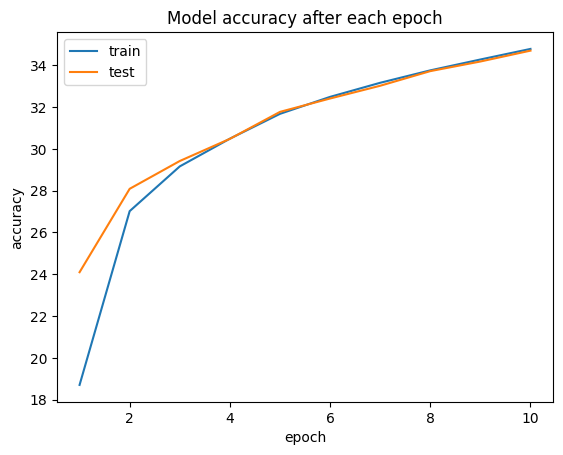

In [ ]:
# visualizing the accuracy curves
plt.plot(range(1,epochs+1), train_accuracy)
plt.plot(range(1,epochs+1), test_accuracy)
plt.title('Model accuracy after each epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

---

Epoch 1
-------------------------------
loss: 2.323852  [   64/50000]
loss: 2.302409  [ 6464/50000]
loss: 2.289577  [12864/50000]
loss: 2.310436  [19264/50000]
loss: 2.275661  [25664/50000]
loss: 2.287371  [32064/50000]
loss: 2.283295  [38464/50000]
loss: 2.279628  [44864/50000]
Test Error: 
 Accuracy: 18.0%, Avg loss: 2.274324 

Epoch 2
-------------------------------
loss: 2.300711  [   64/50000]
loss: 2.278511  [ 6464/50000]
loss: 2.252059  [12864/50000]
loss: 2.286362  [19264/50000]
loss: 2.241446  [25664/50000]
loss: 2.259892  [32064/50000]
loss: 2.259152  [38464/50000]
loss: 2.248532  [44864/50000]
Test Error: 
 Accuracy: 19.5%, Avg loss: 2.240233 

Epoch 3
-------------------------------
loss: 2.275798  [   64/50000]
loss: 2.248474  [ 6464/50000]
loss: 2.202083  [12864/50000]
loss: 2.259603  [19264/50000]
loss: 2.197107  [25664/50000]
loss: 2.221358  [32064/50000]
loss: 2.232634  [38464/50000]
loss: 2.203914  [44864/50000]
Test Error: 
 Accuracy: 21.4%, Avg loss: 2.195546 

Epoc

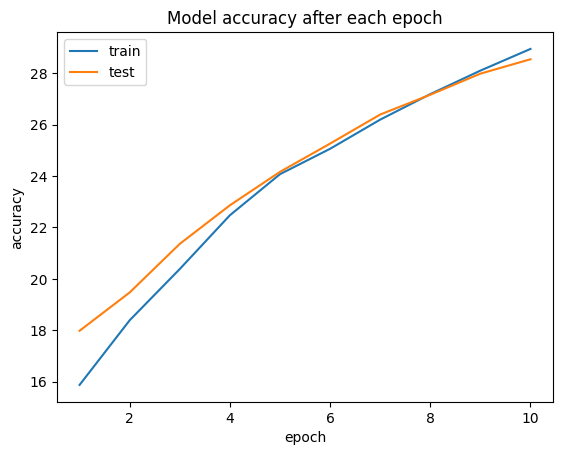

In [ ]:
# Step 3: Create your MLP Network
#--------------------------------------------------------------------------------------------------

import torch
from torch import nn
import pdb

class SimpleMLPv2(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()

    self.network_layers = nn.Sequential(
                nn.Linear(3072, 256),  # linear transformation module (input=3072, output=512)
                nn.ReLU(),
                nn.Linear(256, 128),  # linear transformation module (input=512, output=256)
                nn.ReLU(),
                nn.Linear(128, 10) # linear transformation module (input=256, output=10)
    )

  def forward(self, x):
    x = self.flatten(x)
    output = self.network_layers(x)
    return output


## Step 4: Your training and testing functions
#--------------------------------------------------------------------------------------

def train_loop(dataloader, model, loss_fn, optimizer):
    """
    Executes one full training epoch for the given model.

    Iterates over all batches in the provided DataLoader, performing the following steps:
    - Moves input and target tensors to the selected device (CPU or GPU)
    - Computes predictions and loss for each batch
    - Performs backpropagation and optimizer updates
    - Tracks and prints training loss periodically

    Args:
        dataloader (torch.utils.data.DataLoader):
            The DataLoader providing batches of training data (inputs and labels).
        model (torch.nn.Module):
            The neural network model to be trained.
        loss_fn (torch.nn.Module or callable):
            The loss function used to compute the training loss.
        optimizer (torch.optim.Optimizer):
            The optimizer responsible for updating the model’s parameters.

    Returns:
        float: The average training loss across all batches in this epoch.
    """
    size = len(dataloader.dataset)

    model.train()                   # set the model to training mode for best practices

    size        = len(dataloader.dataset)
    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):

        # compute prediction and loss
        X = X.to(device)                  # send data to the GPU device (if available)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()      # compute gradients
        optimizer.step()     # apply updates
        optimizer.zero_grad()# clear old gradients

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    correct /= size

    return train_loss/len(dataloader), 100*correct

def test_loop(dataloader, model, loss_fn):
    """
    Evaluates the model’s performance on a test (or validation) dataset.

    Runs a forward pass over all batches in the provided DataLoader with gradient
    computation disabled, accumulating loss and accuracy metrics.

    Args:
        dataloader (torch.utils.data.DataLoader):
            The DataLoader providing batches of test or validation data.
        model (torch.nn.Module):
            The trained neural network model to evaluate.
        loss_fn (torch.nn.Module or callable):
            The loss function used to compute the evaluation loss.

    Returns:
        float: The average loss over all test batches.

    Prints:
        Accuracy (% of correct predictions) and average test loss.
    """

    model.eval()                    # set the model to evaluation mode for best practices

    size        = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:

            X = X.to(device)                     # send data to the GPU device (if available)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, 100*correct

# Step 5: prepare the DataLoader and select your optimizer and set the parameters for learning the model from DataLoader
#------------------------------------------------------------------------------------------------------------------------------

mlp_model = SimpleMLPv2() ## model Class name here
mlp_model.to(device)      ## device should have been determined earlier (at top of notebook)
learning_rate = 1e-3
batch_size_val = 64
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(training_data, batch_size=batch_size_val)
test_dataloader = DataLoader(test_data, batch_size=batch_size_val)


train_losses = []
test_losses  = []
train_accuracy = []
test_accuracy  = []
start_time   = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_acc = train_loop(train_dataloader, mlp_model, loss_fn, optimizer)
    avg_test_loss, test_acc  = test_loop(test_dataloader, mlp_model, loss_fn)
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

print("Done!")

print("Total fine-tuning time: %.3f sec" %( (time.time()-start_time)) )
print("Total fine-tuning time: %.3f hrs" %( (time.time()-start_time)/3600) )

print(mlp_model.__class__.__name__, " model has been trained!")

#######
# visualizing the accuracy curves
plt.plot(range(1,epochs+1), train_accuracy)
plt.plot(range(1,epochs+1), test_accuracy)
plt.title('Model accuracy after each epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

Epoch 1
-------------------------------
loss: 2.283093  [   64/50000]
loss: 2.138815  [ 6464/50000]
loss: 1.859747  [12864/50000]
loss: 1.896120  [19264/50000]
loss: 1.992109  [25664/50000]
loss: 1.981559  [32064/50000]
loss: 1.897550  [38464/50000]
loss: 1.789228  [44864/50000]
Test Error: 
 Accuracy: 30.7%, Avg loss: 1.920431 

Epoch 2
-------------------------------
loss: 1.890628  [   64/50000]
loss: 1.775421  [ 6464/50000]
loss: 1.502044  [12864/50000]
loss: 1.820187  [19264/50000]
loss: 1.717802  [25664/50000]
loss: 1.759382  [32064/50000]
loss: 1.756037  [38464/50000]
loss: 1.756420  [44864/50000]
Test Error: 
 Accuracy: 33.9%, Avg loss: 1.794870 

Epoch 3
-------------------------------
loss: 1.776278  [   64/50000]
loss: 1.663652  [ 6464/50000]
loss: 1.357481  [12864/50000]
loss: 1.788454  [19264/50000]
loss: 1.651186  [25664/50000]
loss: 1.630396  [32064/50000]
loss: 1.678307  [38464/50000]
loss: 1.736481  [44864/50000]
Test Error: 
 Accuracy: 37.0%, Avg loss: 1.710457 

Epoc

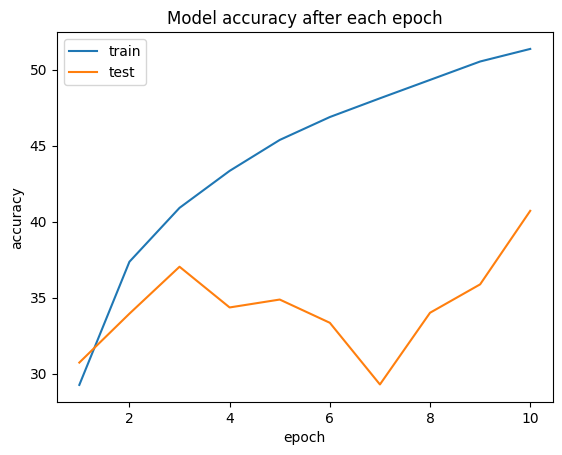

In [ ]:
# Step 3: Create your MLP Network
#--------------------------------------------------------------------------------------------------

import torch
from torch import nn
import pdb

class SimpleMLPv2(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()

    self.network_layers = nn.Sequential(
                nn.Linear(3072, 256),  # linear transformation module (input=3072, output=512)
                nn.ReLU(),
                nn.Linear(256, 128),  # linear transformation module (input=512, output=256)
                nn.ReLU(),
                nn.Linear(128, 10) # linear transformation module (input=256, output=10)
    )

  def forward(self, x):
    x = self.flatten(x)
    output = self.network_layers(x)
    return output


## Step 4: Your training and testing functions
#--------------------------------------------------------------------------------------

def train_loop(dataloader, model, loss_fn, optimizer):
    """
    Executes one full training epoch for the given model.

    Iterates over all batches in the provided DataLoader, performing the following steps:
    - Moves input and target tensors to the selected device (CPU or GPU)
    - Computes predictions and loss for each batch
    - Performs backpropagation and optimizer updates
    - Tracks and prints training loss periodically

    Args:
        dataloader (torch.utils.data.DataLoader):
            The DataLoader providing batches of training data (inputs and labels).
        model (torch.nn.Module):
            The neural network model to be trained.
        loss_fn (torch.nn.Module or callable):
            The loss function used to compute the training loss.
        optimizer (torch.optim.Optimizer):
            The optimizer responsible for updating the model’s parameters.

    Returns:
        float: The average training loss across all batches in this epoch.
    """
    size = len(dataloader.dataset)

    model.train()                   # set the model to training mode for best practices

    size        = len(dataloader.dataset)
    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):

        # compute prediction and loss
        X = X.to(device)                  # send data to the GPU device (if available)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()      # compute gradients
        optimizer.step()     # apply updates
        optimizer.zero_grad()# clear old gradients

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    correct /= size

    return train_loss/len(dataloader), 100*correct

def test_loop(dataloader, model, loss_fn):
    """
    Evaluates the model’s performance on a test (or validation) dataset.

    Runs a forward pass over all batches in the provided DataLoader with gradient
    computation disabled, accumulating loss and accuracy metrics.

    Args:
        dataloader (torch.utils.data.DataLoader):
            The DataLoader providing batches of test or validation data.
        model (torch.nn.Module):
            The trained neural network model to evaluate.
        loss_fn (torch.nn.Module or callable):
            The loss function used to compute the evaluation loss.

    Returns:
        float: The average loss over all test batches.

    Prints:
        Accuracy (% of correct predictions) and average test loss.
    """

    model.eval()                    # set the model to evaluation mode for best practices

    size        = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:

            X = X.to(device)                     # send data to the GPU device (if available)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, 100*correct

# Step 5: prepare the DataLoader and select your optimizer and set the parameters for learning the model from DataLoader
#------------------------------------------------------------------------------------------------------------------------------

mlp_model = SimpleMLPv2() ## model Class name here
mlp_model.to(device)      ## device should have been determined earlier (at top of notebook)
learning_rate = 0.1
batch_size_val = 64
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(training_data, batch_size=batch_size_val)
test_dataloader = DataLoader(test_data, batch_size=batch_size_val)


train_losses = []
test_losses  = []
train_accuracy = []
test_accuracy  = []
start_time   = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_acc = train_loop(train_dataloader, mlp_model, loss_fn, optimizer)
    avg_test_loss, test_acc  = test_loop(test_dataloader, mlp_model, loss_fn)
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

print("Done!")

print("Total fine-tuning time: %.3f sec" %( (time.time()-start_time)) )
print("Total fine-tuning time: %.3f hrs" %( (time.time()-start_time)/3600) )

print(mlp_model.__class__.__name__, " model has been trained!")

#######
# visualizing the accuracy curves
plt.plot(range(1,epochs+1), train_accuracy)
plt.plot(range(1,epochs+1), test_accuracy)
plt.title('Model accuracy after each epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

Epoch 1
-------------------------------
loss: 2.304382  [  128/50000]
loss: 2.252489  [12928/50000]
loss: 2.219074  [25728/50000]
loss: 2.154612  [38528/50000]
Test Error: 
 Accuracy: 24.9%, Avg loss: 2.094075 

Epoch 2
-------------------------------
loss: 2.119582  [  128/50000]
loss: 1.999584  [12928/50000]
loss: 2.019137  [25728/50000]
loss: 2.000461  [38528/50000]
Test Error: 
 Accuracy: 29.4%, Avg loss: 1.960163 

Epoch 3
-------------------------------
loss: 1.975120  [  128/50000]
loss: 1.839964  [12928/50000]
loss: 1.954798  [25728/50000]
loss: 1.915977  [38528/50000]
Test Error: 
 Accuracy: 32.6%, Avg loss: 1.894347 

Epoch 4
-------------------------------
loss: 1.900624  [  128/50000]
loss: 1.761610  [12928/50000]
loss: 1.919557  [25728/50000]
loss: 1.867206  [38528/50000]
Test Error: 
 Accuracy: 34.6%, Avg loss: 1.848676 

Epoch 5
-------------------------------
loss: 1.842809  [  128/50000]
loss: 1.717947  [12928/50000]
loss: 1.892516  [25728/50000]
loss: 1.833560  [38528

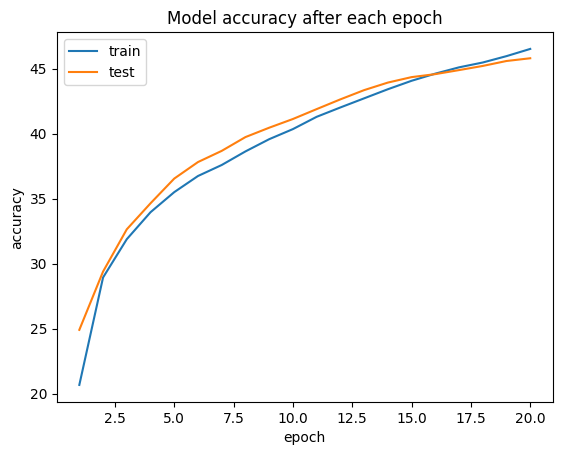

In [ ]:
# Step 3: Create your MLP Network
#--------------------------------------------------------------------------------------------------

import torch
from torch import nn
import pdb

class SimpleMLPv2(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()

    self.network_layers = nn.Sequential(
                nn.Linear(3072, 256),  # linear transformation module (input=3072, output=512)
                nn.ReLU(),
                nn.Linear(256, 128),  # linear transformation module (input=512, output=256)
                nn.ReLU(),
                nn.Linear(128, 10) # linear transformation module (input=256, output=10)
    )

  def forward(self, x):
    x = self.flatten(x)
    output = self.network_layers(x)
    return output


## Step 4: Your training and testing functions
#--------------------------------------------------------------------------------------

def train_loop(dataloader, model, loss_fn, optimizer):
    """
    Executes one full training epoch for the given model.

    Iterates over all batches in the provided DataLoader, performing the following steps:
    - Moves input and target tensors to the selected device (CPU or GPU)
    - Computes predictions and loss for each batch
    - Performs backpropagation and optimizer updates
    - Tracks and prints training loss periodically

    Args:
        dataloader (torch.utils.data.DataLoader):
            The DataLoader providing batches of training data (inputs and labels).
        model (torch.nn.Module):
            The neural network model to be trained.
        loss_fn (torch.nn.Module or callable):
            The loss function used to compute the training loss.
        optimizer (torch.optim.Optimizer):
            The optimizer responsible for updating the model’s parameters.

    Returns:
        float: The average training loss across all batches in this epoch.
    """
    size = len(dataloader.dataset)

    model.train()                   # set the model to training mode for best practices

    size        = len(dataloader.dataset)
    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):

        # compute prediction and loss
        X = X.to(device)                  # send data to the GPU device (if available)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()      # compute gradients
        optimizer.step()     # apply updates
        optimizer.zero_grad()# clear old gradients

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    correct /= size

    return train_loss/len(dataloader), 100*correct

def test_loop(dataloader, model, loss_fn):
    """
    Evaluates the model’s performance on a test (or validation) dataset.

    Runs a forward pass over all batches in the provided DataLoader with gradient
    computation disabled, accumulating loss and accuracy metrics.

    Args:
        dataloader (torch.utils.data.DataLoader):
            The DataLoader providing batches of test or validation data.
        model (torch.nn.Module):
            The trained neural network model to evaluate.
        loss_fn (torch.nn.Module or callable):
            The loss function used to compute the evaluation loss.

    Returns:
        float: The average loss over all test batches.

    Prints:
        Accuracy (% of correct predictions) and average test loss.
    """

    model.eval()                    # set the model to evaluation mode for best practices

    size        = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:

            X = X.to(device)                     # send data to the GPU device (if available)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, 100*correct

# Step 5: prepare the DataLoader and select your optimizer and set the parameters for learning the model from DataLoader
#------------------------------------------------------------------------------------------------------------------------------

mlp_model = SimpleMLPv2() ## model Class name here
mlp_model.to(device)      ## device should have been determined earlier (at top of notebook)
learning_rate = 0.01
batch_size_val = 128
epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(training_data, batch_size=batch_size_val)
test_dataloader = DataLoader(test_data, batch_size=batch_size_val)


train_losses = []
test_losses  = []
train_accuracy = []
test_accuracy  = []
start_time   = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_acc = train_loop(train_dataloader, mlp_model, loss_fn, optimizer)
    avg_test_loss, test_acc  = test_loop(test_dataloader, mlp_model, loss_fn)
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

print("Done!")

print("Total fine-tuning time: %.3f sec" %( (time.time()-start_time)) )
print("Total fine-tuning time: %.3f hrs" %( (time.time()-start_time)/3600) )

print(mlp_model.__class__.__name__, " model has been trained!")

#######
# visualizing the accuracy curves
plt.plot(range(1,epochs+1), train_accuracy)
plt.plot(range(1,epochs+1), test_accuracy)
plt.title('Model accuracy after each epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# Convolutional Networks!!

Epoch 1
-------------------------------
loss: 2.304924  [  128/50000]
loss: 2.247482  [12928/50000]
loss: 2.128865  [25728/50000]
loss: 2.103933  [38528/50000]
Test Error: 
 Accuracy: 31.4%, Avg loss: 1.929004 

Epoch 2
-------------------------------
loss: 1.946123  [  128/50000]
loss: 1.847909  [12928/50000]
loss: 1.956160  [25728/50000]
loss: 1.825904  [38528/50000]
Test Error: 
 Accuracy: 37.4%, Avg loss: 1.778646 

Epoch 3
-------------------------------
loss: 1.773995  [  128/50000]
loss: 1.688710  [12928/50000]
loss: 1.796443  [25728/50000]
loss: 1.704339  [38528/50000]
Test Error: 
 Accuracy: 41.2%, Avg loss: 1.666486 

Epoch 4
-------------------------------
loss: 1.657199  [  128/50000]
loss: 1.583983  [12928/50000]
loss: 1.662102  [25728/50000]
loss: 1.614239  [38528/50000]
Test Error: 
 Accuracy: 44.4%, Avg loss: 1.573433 

Epoch 5
-------------------------------
loss: 1.555924  [  128/50000]
loss: 1.503223  [12928/50000]
loss: 1.566920  [25728/50000]
loss: 1.539410  [38528

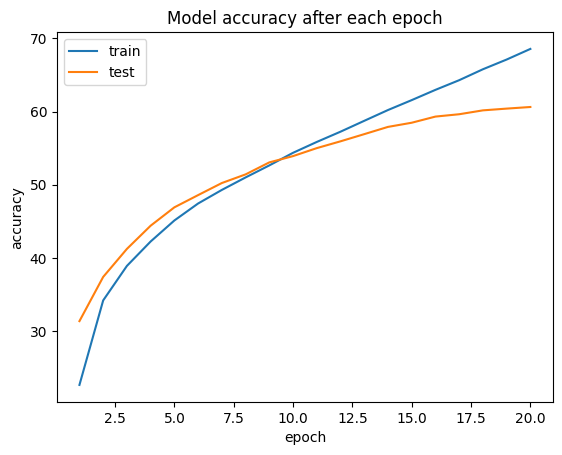

In [ ]:
# Step 3: Create your CNN Network (call it SimpleCNNv2) with 2 conv_2d layers + 2 layers of MLP
#--------------------------------------------------------------------------------------------------

class SimpleCNNv1(nn.Module):
  def __init__(self):
    super().__init__()
    # your network layer construction should take place here

    # note input image is greyscale and has dimension of [1,28,28]

    # Beginning layers: a series of 2D convolutional layers (useful for feature map learning from the grid layouts of an image)
    self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3),   # -> maps input grey scale image (3 channel) to a conv layer of 32 channels; output dimension of [32,30,30]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),  # -> input of 32 channels to conv. layer of 64 channels; output dimensions of [64,28,28]
            nn.ReLU()
    )

    # --------------------------------------------------------------------------
    # -------                 heads up!                                 --------
    # you need to calculate the total_size_of_the_output_volume of your self.second_conv_2d layer,
    # as it will be needed by the upcoming nn.Linear(). This number will be used as the first argument for the next nn.Linear().
    # I pre-calculated this number, and it is 64*28*28 = 50176. I will plug this number in the next layer
    # --------------------------------------------------------------------------

    self.flatten = nn.Flatten() # -> flatten the tensor to prepare for a fully connected MLP layer; resulting layer is [64*24*24]

    self.linear_layers = nn.Sequential(
            nn.Linear(64*28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)     # 10 is the number of classes in the classification task
    )

  def forward(self, x):
    # your code for Conv_2d forward pass should take place here
    output = self.conv_layers(x)
    output = self.flatten(output)
    output = self.linear_layers(output)
    return output


## Step 4: Your training and testing functions
#--------------------------------------------------------------------------------------

def train_loop(dataloader, model, loss_fn, optimizer):
    """
    Executes one full training epoch for the given model.

    Iterates over all batches in the provided DataLoader, performing the following steps:
    - Moves input and target tensors to the selected device (CPU or GPU)
    - Computes predictions and loss for each batch
    - Performs backpropagation and optimizer updates
    - Tracks and prints training loss periodically

    Args:
        dataloader (torch.utils.data.DataLoader):
            The DataLoader providing batches of training data (inputs and labels).
        model (torch.nn.Module):
            The neural network model to be trained.
        loss_fn (torch.nn.Module or callable):
            The loss function used to compute the training loss.
        optimizer (torch.optim.Optimizer):
            The optimizer responsible for updating the model’s parameters.

    Returns:
        float: The average training loss across all batches in this epoch.
    """
    size = len(dataloader.dataset)

    model.train()                   # set the model to training mode for best practices

    size        = len(dataloader.dataset)
    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):

        # compute prediction and loss
        X = X.to(device)                  # send data to the GPU device (if available)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()      # compute gradients
        optimizer.step()     # apply updates
        optimizer.zero_grad()# clear old gradients

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    correct /= size

    return train_loss/len(dataloader), 100*correct

def test_loop(dataloader, model, loss_fn):
    """
    Evaluates the model’s performance on a test (or validation) dataset.

    Runs a forward pass over all batches in the provided DataLoader with gradient
    computation disabled, accumulating loss and accuracy metrics.

    Args:
        dataloader (torch.utils.data.DataLoader):
            The DataLoader providing batches of test or validation data.
        model (torch.nn.Module):
            The trained neural network model to evaluate.
        loss_fn (torch.nn.Module or callable):
            The loss function used to compute the evaluation loss.

    Returns:
        float: The average loss over all test batches.

    Prints:
        Accuracy (% of correct predictions) and average test loss.
    """

    model.eval()                    # set the model to evaluation mode for best practices

    size        = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:

            X = X.to(device)                     # send data to the GPU device (if available)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, 100*correct


# Step 5: prepare the DataLoader and select your optimizer and set the parameters for learning the model from DataLoader
#------------------------------------------------------------------------------------------------------------------------------
mlp_model = SimpleCNNv1() ## model Class name here
mlp_model.to(device)      ## device should have been determined earlier (at top of notebook)
learning_rate = 0.01
batch_size_val = 128
epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(training_data, batch_size=batch_size_val)
test_dataloader = DataLoader(test_data, batch_size=batch_size_val)


train_losses = []
test_losses  = []
train_accuracy = []
test_accuracy  = []
start_time   = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_acc = train_loop(train_dataloader, mlp_model, loss_fn, optimizer)
    avg_test_loss, test_acc  = test_loop(test_dataloader, mlp_model, loss_fn)
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

print("Done!")

print("Total fine-tuning time: %.3f sec" %( (time.time()-start_time)) )
print("Total fine-tuning time: %.3f hrs" %( (time.time()-start_time)/3600) )

print(mlp_model.__class__.__name__, " model has been trained!")

#######
# visualizing the accuracy curves
plt.plot(range(1,epochs+1), train_accuracy)
plt.plot(range(1,epochs+1), test_accuracy)
plt.title('Model accuracy after each epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()